In [5]:
import matplotlib.pyplot as plt
import ase
from ase import io
from ase.visualize import view
from glob import glob
from pathlib import Path
import json
import pandas as pd
import numpy as np
import polars as pl
import polars as pl
import matplotlib.pyplot as plt
import sys
import ase
import numpy as np
import scipy.optimize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pathlib import Path
from enum import Enum
from ase.units import Hartree, kcal, mol
from dftmp2bench.pareto import is_pareto_efficient
from scipy.stats import linregress



In [6]:
class Software(Enum):
    ORCA = "orca"
    GAUSSIAN = "gaussian"

class Dfcols(Enum):
    MOLECNAME = "molecule_name"
    WALLTIME = "wall_time"
    LOT = "level_of_theory"
    BASIS = "basis"
    SOFTWARE = "software"
    ENERGY = "energy"
    THEORYTYPE = "theory_type"
    RELWALLTIME = "relative_walltime" #"wall_time" 
    ABSERRORKCAL = "absolute_error_kcalmol"
    NBASIS = "nbasis"
    

In [2]:
project_path = Path("/cluster/home/schmidtn/master/wahlprak/dftmp2bench")
csv_path = project_path / "csvs" / "summary-charge_test2-2025-02-04-105a6652-e2ea-11ef-8425-5379090b8daf.csv" #tag = charge_test2

Text(0, 0.5, 'deltaE(PBE0)')

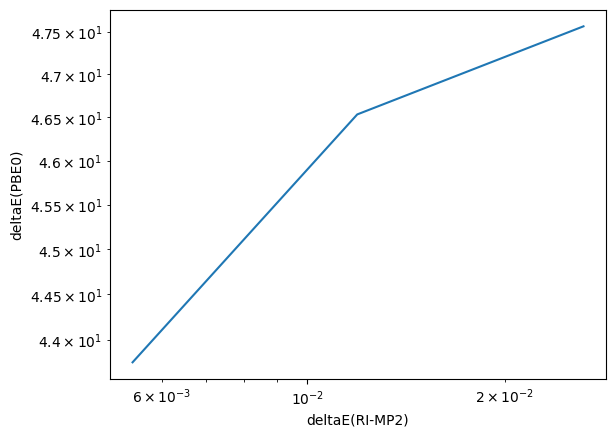

In [111]:
q = (pl.scan_csv(csv_path))
df = q.collect()

"""
split the df into multiple dfs by molecule name  
"""
#dfs = pl.dataframe
dfsplit = df.partition_by([Dfcols.MOLECNAME.value])
minrg = dfsplit[2].filter((pl.col("level_of_theory") == "mp2") & (pl.col("software") == "orca"))

method1 = "rimp2"
method2 = "pbe0"

xdf = dfsplit[2].filter((pl.col("level_of_theory") == method1) & (pl.col("software") == "orca"))
ydf = dfsplit[2].filter((pl.col("level_of_theory") == method2) & (pl.col("software") == "orca"))

# print(xdf.select(pl.col("level_of_theory"), pl.col("basis"), pl.col("energy") ))
# print(ydf.select(pl.col("level_of_theory"), pl.col("basis"), pl.col("energy") ))

#bases = []
availbasis = [
    "def2svp",
    "def2svpd",
    "ccpvdz"
]

#xdfbasis = xdf.select("basis")

# for basis in xdfbasis.iter_rows():
#     bases.append(basis)
# #print(bases)

# for (basis, ) in bases:
#     if basis in minrg.select("basis"):
#         availbasis.append(basis)
# #print(availbasis)



# print(minrg.select("basis"))
# print(xdf.select("basis"))



#if basis in minrg.select("basis"):
#if basis.is_in(minrg.select("basis")):
    #availbasis.append(basis)
#else: pass

#print(availbasis)



xvals = []
yvals = []

for basis in availbasis:

    method1basis = xdf.filter(pl.col("basis") == basis)
    method2basis = ydf.filter(pl.col("basis") == basis)
    mp2basis = minrg.filter(pl.col("basis") == basis)
    
    
    xval = method1basis.select("energy") - mp2basis.select("energy")
    xvals.append(abs(xval.item()))
    yval = method2basis.select("energy") - mp2basis.select("energy")
    yvals.append(abs(yval.item()))
    
    #print(method1basis)
    #print(mp2basis)

xvals.sort()
yvals.sort()
# print(xvals)
# print(yvals)

ax = plt.gca()

plt.plot(xvals, yvals)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("deltaE(RI-MP2)")
ax.set_ylabel("deltaE(PBE0)")

# plt.xlim(0, 0.2)
# plt.ylim(44, 48)

